In [30]:
import torch
import torch.nn as nn
from torch.autograd import Variable

from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as tfs
import torch.nn.functional as F
from data import YourNameVAEDataset, get_vae_transformer, get_split_vae_dataset
import tqdm
import glob
import random
import json
import os.path as osp
import matplotlib.pyplot as plt

from torch.utils.tensorboard import SummaryWriter
from IPython.display import display, clear_output
Display = lambda img_tensor: display(tfs.ToPILImage()(img_tensor).convert("RGB"))

In [31]:
with open('fn_index.json','r') as fp:
    ranges = json.load(fp)['ranges']

In [32]:
len(ranges)

31

In [33]:
filenames = glob.glob(osp.join('../project/data/png/142p', '*.png'))
filenames.sort()
train_val_ratios = (0.8, 0.1)
train_filenames = []
val_filenames = []
test_filenames = []
for start, end in ranges[0:15]:
    scene_filenames = filenames[start: end]
    random.shuffle(scene_filenames)
    train_cnt = int(len(scene_filenames) * train_val_ratios[0])
    val_cnt = int(len(scene_filenames) * train_val_ratios[1])
    test_cnt = len(scene_filenames) - train_cnt - val_cnt
    train_filenames.extend(scene_filenames[0:train_cnt])
    val_filenames.extend(scene_filenames[train_cnt: train_cnt+val_cnt])
    test_filenames.extend(scene_filenames[train_cnt+val_cnt:])
print(len(train_filenames), len(val_filenames), len(test_filenames))

801 95 111


In [34]:
vae_transformer = get_vae_transformer(img_size=(142, 189), out_size=(64, 64))
# vae_dataset = YourNameVAEDataset('../project/data/png/142p', isPatch=False, img_size=(142, 189), transform = vae_transformer, filenames=selected_filenames)
# vae_dataset = YourNameVAEDataset('../project/data/png/142p', isPatch=False, img_size=(142, 189), transform = vae_transformer)

train_vae_dataset = YourNameVAEDataset('../project/data/png/142p', isPatch=False, img_size=(142, 189), transform = vae_transformer, filenames=train_filenames)
val_vae_dataset = YourNameVAEDataset('../project/data/png/142p', isPatch=False, img_size=(142, 189), transform = vae_transformer, filenames=val_filenames)
test_vae_dataset = YourNameVAEDataset('../project/data/png/142p', isPatch=False, img_size=(142, 189), transform = vae_transformer, filenames=test_filenames)


train_vae_dataloader = DataLoader(train_vae_dataset, shuffle=True, batch_size=16, pin_memory=True, num_workers=8)
val_vae_dataloader = DataLoader(val_vae_dataset, shuffle=True, batch_size=512, pin_memory=True, num_workers=8)
test_vae_dataloader = DataLoader(test_vae_dataset, shuffle=True, batch_size=512, pin_memory=True, num_workers=8)

In [35]:
len(train_vae_dataset), len(val_vae_dataset), len(test_vae_dataset)

(801, 95, 111)

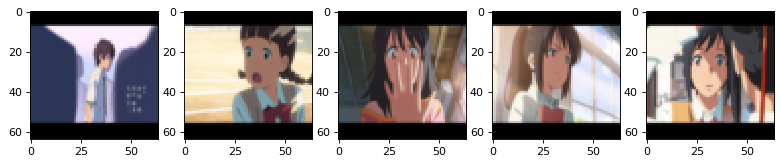

In [36]:
toPILImage = tfs.ToPILImage()
plt.figure(num=None, figsize=(12,8), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1, 5, 1)
plt.imshow(toPILImage(train_vae_dataset[10]))
plt.subplot(1, 5, 2)
plt.imshow(toPILImage(train_vae_dataset[200]))
plt.subplot(1, 5, 3)
plt.imshow(toPILImage(train_vae_dataset[390]))
plt.subplot(1, 5, 4)
plt.imshow(toPILImage(train_vae_dataset[450]))
plt.subplot(1, 5, 5)
plt.imshow(toPILImage(train_vae_dataset[550]))

In [68]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)

class ConvVAE(nn.Module):
    def __init__(self, latent_cnt):
        super(ConvVAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            Reshape(-1, 256*4*4),
            nn.Linear(256*4*4, 1024)
        )
        
        self.mean_layer = nn.Linear(1024, latent_cnt)
        self.logvar_layer = nn.Linear(1024, latent_cnt)
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_cnt, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256*4*4),
            nn.ReLU(),
            Reshape(-1, 256, 4, 4),
            nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
        )
    
    def encode(self, x):
        x = self.encoder(x)
        mu, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mu, logvar
    
    def decode(self, z):
        x = self.decoder(z)
        return x
    
    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [69]:
model = ConvVAE(64).cuda()
writer = SummaryWriter('runs/beta_vae')

In [9]:
optimizer = torch.optim.Adagrad(model.parameters(), lr=1e-4)
def criterion(recon_x, x, mu, logvar, beta):
    bce = F.binary_cross_entropy(recon_x, x, reduction='sum')
    kld = (-0.5 * (1 + logvar - mu.pow(2) - logvar.exp())).sum()
    return bce, kld, bce + beta*kld

In [10]:
def train(model, optimizer, data_loader):
    model.train()
    total_loss = 0
#     pbar = tqdm.tqdm(data_loader)
    i = 0
    mean_bce = 0
    mean_kl = 0
    mean_loss = 0
    for batch_x in data_loader:
        i += 1
        batch_x = batch_x.cuda()
        recon_batch_x, mu, logvar = model(batch_x)
        optimizer.zero_grad()
        bce, kld, loss = criterion(recon_batch_x, batch_x, mu, logvar, 4)
        loss.backward()
        optimizer.step()
        writer.add_scalar('train bce loss', bce.item()/len(batch_x), epoch*len(data_loader) + i)
        writer.add_scalar('train kl divergence', kld.item()/len(batch_x), epoch*len(data_loader) + i)
        writer.add_scalar('train total loss', loss.item()/len(batch_x), epoch*len(data_loader) + i)
        mean_bce += bce.item()
        mean_kl += kld.item()
        mean_loss += loss.item()
#         if i % 20 == 0:
#             pbar.set_description('BCE Loss: {}, KL Loss: {}, Beta VAE Loss: {}'.format(bce.item(), kld.item(), loss.item()))
    mean_bce /= len(data_loader.dataset)
    mean_kl /= len(data_loader.dataset)
    mean_loss /= len(data_loader.dataset)
    print('Train: BCE Loss: {}, KL Loss: {}, Beta VAE Loss: {}'.format(mean_bce, mean_kl, mean_loss))

In [11]:
def eval(model, data_loader, tag='validate'):
    model.train()
    i = 0
    mean_bce = 0
    mean_kl = 0
    mean_loss = 0
    for batch_x in data_loader:
        i += 1
        batch_x = batch_x.cuda()
        recon_batch_x, mu, logvar = model(batch_x)
        bce, kld, loss = criterion(recon_batch_x, batch_x, mu, logvar, 4)
        writer.add_scalar('{} bce loss'.format(tag), bce.item()/len(batch_x), epoch*len(data_loader) + i)
        writer.add_scalar('{} kl divergence'.format(tag), kld.item()/len(batch_x), epoch*len(data_loader) + i)
        writer.add_scalar('{} total loss'.format(tag), loss.item()/len(batch_x), epoch*len(data_loader) + i)
        mean_bce += bce.item()
        mean_kl += kld.item()
        mean_loss += loss.item()
    mean_bce /= len(data_loader.dataset)
    mean_kl /= len(data_loader.dataset)
    mean_loss /= len(data_loader.dataset)
    print('{}: BCE Loss: {}, KL Loss: {}, Beta VAE Loss: {}'.format(tag, mean_bce, mean_kl, mean_loss))

In [12]:
epoch_n = 900
for epoch in range(epoch_n):
    print(epoch)
    train(model, optimizer, train_vae_dataloader)
    eval(model, val_vae_dataloader, 'validate')
    eval(model, test_vae_dataloader, 'test')
    torch.save(model.state_dict(), 'weights/baseline_{}.w'.format(epoch))

0
Train: BCE Loss: 8483.18906664521, KL Loss: 0.460715395680974, Beta VAE Loss: 8485.031947370475
validate: BCE Loss: 8380.208552631579, KL Loss: 2.3349198190789475, Beta VAE Loss: 8389.54802631579
test: BCE Loss: 8382.011261261261, KL Loss: 2.294037552567216, Beta VAE Loss: 8391.1875
1
Train: BCE Loss: 8104.678775553995, KL Loss: 13.953910120417563, Beta VAE Loss: 8160.494401529339
validate: BCE Loss: 7747.290131578948, KL Loss: 28.759421258223686, Beta VAE Loss: 7862.327631578947
test: BCE Loss: 7741.935810810811, KL Loss: 28.27740313555743, Beta VAE Loss: 7855.045608108108
2
Train: BCE Loss: 7452.12715428956, KL Loss: 35.62856417499976, Beta VAE Loss: 7594.641392473276
validate: BCE Loss: 7223.094736842106, KL Loss: 38.03787777549342, Beta VAE Loss: 7375.246052631579
test: BCE Loss: 7224.587274774774, KL Loss: 37.46423229870496, Beta VAE Loss: 7374.444256756757
3
Train: BCE Loss: 7085.329438665535, KL Loss: 37.772816694928764, Beta VAE Loss: 7236.420706416784
validate: BCE Loss: 696